In [2]:
import math
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
train = pd.read_csv('/kaggle/input/us-adult-income-update/train.csv')
test = pd.read_csv('/kaggle/input/us-adult-income-update/test.csv')
test = test.drop(columns=['income'], axis=1)
train

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


In [4]:
CATEGORICAL_FEATURES = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
NUMERICAL_FEATURES = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
TARGET = 'income'

### We convert the target column from string to integer.

In [5]:
labelencoder = LabelEncoder()
train[TARGET] = labelencoder.fit_transform(train[TARGET])

# Extract categorical features from train DataFrame
categorical_features = train[CATEGORICAL_FEATURES]

# Initialize the OneHotEncoder and fit it to the combined dataset
onehotencoder = OneHotEncoder()
encoded_features = onehotencoder.fit_transform(categorical_features)

# Convert the encoded features to a DataFrame
encoded_df = pd.DataFrame(encoded_features.toarray(), columns=onehotencoder.get_feature_names_out())

# Concatenate the original DataFrame with the encoded categorical features
train_encoded = pd.concat([train.drop(columns=CATEGORICAL_FEATURES), encoded_df], axis=1)

# Apply the same transformation to the test dataset
test_categorical_features = test[CATEGORICAL_FEATURES]
encoded_test_features = onehotencoder.transform(test_categorical_features)
encoded_test_df = pd.DataFrame(encoded_test_features.toarray(), columns=onehotencoder.get_feature_names_out())
test_encoded = pd.concat([test.drop(columns=CATEGORICAL_FEATURES), encoded_test_df], axis=1)
train_encoded = pd.concat([train.drop(columns=CATEGORICAL_FEATURES), encoded_df], axis=1)
train_encoded.drop(columns=['income'], axis=1, inplace=True) # Drop the target

In [6]:
labels = train[TARGET]

# Convert encoded features to dense tensors
dense_features_train = train_encoded.to_numpy()
dense_features_test = test_encoded.to_numpy()

In [7]:
# Split the data into training and validation sets
train_features, val_features, train_labels, val_labels = train_test_split(dense_features_train, labels, test_size=0.2, random_state=42)

# Create TensorFlow datasets for training and validation
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_features, val_labels))

# Shuffle and batch the datasets
batch_size = 265
train_dataset = train_dataset.shuffle(buffer_size=len(train_features)).batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [8]:
# Convert test_encoded to a NumPy array with compatible data type
dense_features_test = test_encoded.astype(float).to_numpy()

# Create a TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices(dense_features_test)

# Batch the test dataset (optional, depends on your requirements)
batch_size = 265
test_dataset = test_dataset.batch(batch_size)

In [9]:
# Define your model architecture
class GatedLinearUnit(layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.linear = layers.Dense(units)
        self.sigmoid = layers.Dense(units, activation="sigmoid")

    def call(self, inputs):
        return self.linear(inputs) * self.sigmoid(inputs)

In [10]:
class GatedResidualNetwork(layers.Layer):
    def __init__(self, units, dropout_rate):
        super().__init__()
        self.units = units
        self.elu_dense = layers.Dense(units, activation="elu")
        self.linear_dense = layers.Dense(units)
        self.dropout = layers.Dropout(dropout_rate)
        self.gated_linear_unit = GatedLinearUnit(units)
        self.layer_norm = layers.LayerNormalization()
        self.project = layers.Dense(units)

    def call(self, inputs):
        # Ensure inputs are at least 2D
        if len(inputs.shape) == 1:
            inputs = tf.expand_dims(inputs, axis=1)

        x = self.elu_dense(inputs)
        x = self.linear_dense(x)
        x = self.dropout(x)
        if inputs.shape[-1] != self.units:
            inputs = self.project(inputs)
        x = inputs + self.gated_linear_unit(x)
        x = self.layer_norm(x)
        return x

In [11]:
class VariableSelection(layers.Layer):
    def __init__(self, num_features, units, dropout_rate):
        super().__init__()
        self.grns = list()
        # Create a GRN for each feature independently
        for _ in range(num_features):
            grn = GatedResidualNetwork(units, dropout_rate)
            self.grns.append(grn)
        # Create a GRN for the concatenation of all the features
        self.grn_concat = GatedResidualNetwork(units, dropout_rate)
        self.softmax = layers.Dense(units=num_features, activation="softmax")

    def call(self, inputs):
        x_list = [grn(input_) for grn, input_ in zip(self.grns, tf.unstack(inputs, axis=1))]
        v = layers.concatenate(x_list)
        v = self.grn_concat(v)
        v = tf.expand_dims(self.softmax(v), axis=-1)

        outputs = tf.reduce_sum(v * tf.stack(x_list, axis=1), axis=1)
        return outputs

In [12]:
def create_model(encoding_size):
    num_features = dense_features_train.shape[1]  # Assuming all features are used
    inputs = keras.Input(shape=(num_features,))
    features = VariableSelection(num_features, encoding_size, dropout_rate)(inputs)
    outputs = layers.Dense(units=1, activation="sigmoid")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

Start training the model...
Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 255s 192ms/step - accuracy: 0.7490 - loss: 0.5137 - val_accuracy: 0.8319 - val_loss: 0.3588
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.8327 - loss: 0.3563 - val_accuracy: 0.8280 - val_loss: 0.3633
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.8385 - loss: 0.3496 - val_accuracy: 0.8417 - val_loss: 0.3509
Epoch 4/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 96ms/step - accuracy: 0.8372 - loss: 0.3486 - val_accuracy: 0.8457 - val_loss: 0.3405
Epoch 5/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 96ms/step - accuracy: 0.8376 - loss: 0.3439 - val_accuracy: 0.8458 - val_loss: 0.3396
Epoch 6/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8387 - loss: 0.3436 - val_accuracy: 0.8396 - val_loss: 0.3426
Epoch 7/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.8444 - loss: 0.3389 - val_accuracy: 0.8455 - val_loss: 0.3348
Epoch 8/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.8394 - loss

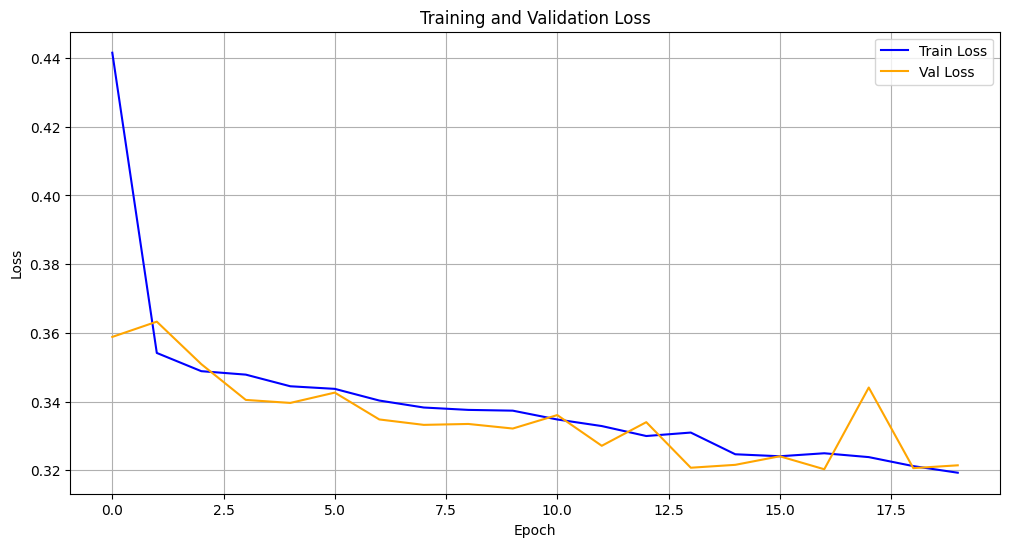

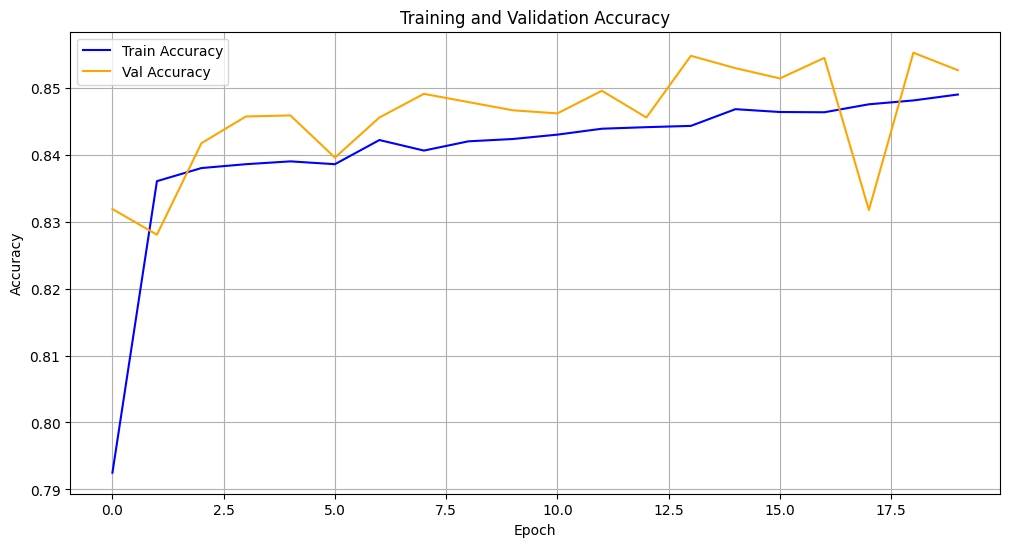

In [13]:
learning_rate = 0.001
dropout_rate = 0.15
batch_size = 265
num_epochs = 20
encoding_size = 16

model = create_model(encoding_size)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.BinaryCrossentropy(),
    metrics=[keras.metrics.BinaryAccuracy(name="accuracy")],
)

# Create an early stopping callback.
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)

print("Start training the model...")
history = model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,  
    callbacks=[early_stopping],
)
print("Model training finished.")

print("Evaluating model performance...")
_, accuracy = model.evaluate(val_dataset)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# Get training and validation loss values
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Get training and validation accuracy values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot training and validation losses
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Val Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracies
plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(val_acc, label='Val Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Make predictions on the test dataset
predictions = model.predict(test_dataset)

# Optionally, you can threshold the predictions for binary classification
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)

# Print the first few predictions
print(binary_predictions[:10]) 

62/62 ━━━━━━━━━━━━━━━━━━━━ 19s 167ms/step
[[0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]]
